In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from diffusers import AutoencoderKL
from diffusers import BitsAndBytesConfig
from diffusers import StableDiffusionInpaintPipeline
from diffusers import UNet2DConditionModel
from PIL import Image

torch.backends.cuda.matmul.allow_tf32 = True

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

dtype = torch.float16

model_version = "stabilityai/stable-diffusion-2-inpainting"
DCS = False
username = "sneakers-pretrained-models"
if DCS:
  models_path = f"/dcs/large/{username}"
else:
  models_path = None

nf4_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=dtype,
)
unet_nf4 = UNet2DConditionModel.from_pretrained(
    model_version,
    subfolder="unet",
    quantization_config=nf4_config,
    torch_dtype=dtype,
    use_safetensors=True,
    cache_dir=models_path,
)

vae_nf4 = AutoencoderKL.from_pretrained(
    model_version,
    subfolder="vae",
    quantization_config=nf4_config,
    torch_dtype=dtype,
    use_safetensors=True,
    cache_dir=models_path,
)

pipe_inpaint: StableDiffusionInpaintPipeline = StableDiffusionInpaintPipeline.from_pretrained(
    model_version,
    variant="fp16",
    unet=unet_nf4,
    vae=vae_nf4,
    torch_dtype=dtype,
    use_safetensors=True,
    cache_dir=models_path,
)  # type: ignore
pipe_inpaint = pipe_inpaint.to(device=device, memory_format=torch.channels_last)

# pipe_inpaint.text_encoder = pipe_inpaint.text_encoder.to(device, dtype)
# pipe_inpaint.unet.to(memory_format=torch.channels_last)
# pipe_inpaint = pipe_inpaint.to(device=device, memory_format=torch.channels_last)
# pipe_inpaint.safety_checker = None
pipe_inpaint.vae.requires_grad_(False)
pipe_inpaint.unet.requires_grad_(False)

# pipe = torch.compile(pipe)

Using device: cuda


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

UNet2DConditionModel(
  (conv_in): Conv2d(9, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear4bit(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear4bit(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Linear4bit(in_features=320, out_features=320, bias=True)
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear4bit(in_features=320, out_features=320, bias=False)
                (to_k): Linear4bit(in_features=320, out_features=320, bias=False)
                (to_v): Linear4bi

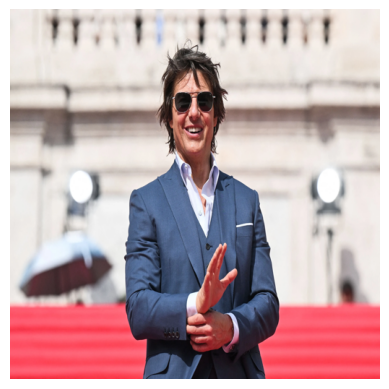

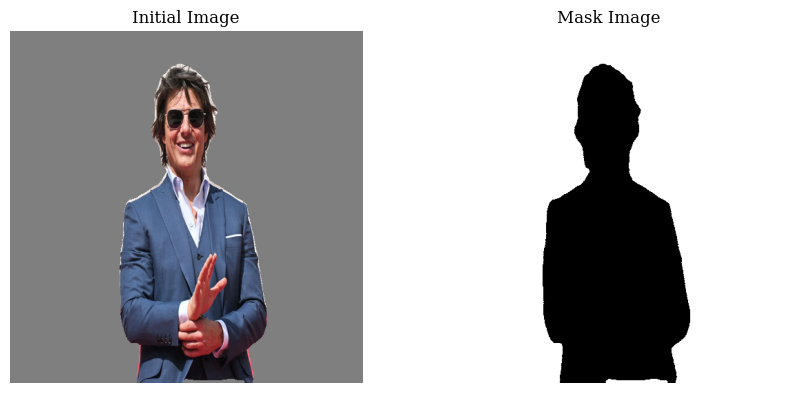

In [ ]:
def prepare_mask_and_masked(
    image: Image.Image,
    mask: Image.Image,
) -> tuple[torch.Tensor, torch.Tensor]:
  """
    Preprocesses an image and mask for deep learning models.

    Args:
        image: Input image (PIL Image)
        mask: Input mask (PIL Image)
        inverted: If True, inverts the mask values

    Returns:
        (mask_tensor, masked_image_tensor)
    """
  # Convert image to tensor and normalize
  image_torch = torch.tensor(
      np.array(image.convert("RGB")), dtype=torch.float32
  )
  image_torch = image_torch.permute(2, 0, 1).unsqueeze(0)
  image_torch = image_torch / 127.5 - 1.0

  # Convert mask to binary tensor
  mask_torch = torch.tensor(np.array(mask.convert("L")), dtype=torch.float32)
  mask_torch = mask_torch / 255.0
  mask_torch = mask_torch[None, None]
  mask_torch = (mask_torch >= 0.5).float()
  mask_torch = 1 - mask_torch

  masked_image = image_torch * (mask_torch < 0.5)

  return mask_torch, masked_image


# Load initial image
image_dir = "./images/"
image_name = "005.png"
mask_name = "005_masked.png"
# prompt = "an office with a desk and a computer with a window to the park"  # 002
prompt = "a man wearing a suit in a posh restaurant for a date"  # 005
# prompt = "two guys on a plane"  # 008
# Check if files exist
init_image = plt.imread(image_dir + image_name, format="RGB")
mask_image = plt.imread(image_dir + mask_name)

size_2d = (512, 512)

init_image = Image.open(image_dir + image_name).convert('RGB').resize(size_2d)
plt.imshow(init_image)
plt.axis("off")
plt.show()
mask_image = Image.open(image_dir + mask_name).convert('RGB').resize(size_2d)
# mask_image = ImageOps.invert(mask_image).resize(size_2d)

mask_image, init_image = prepare_mask_and_masked(init_image, mask_image)

# Plot the initial image and mask
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(init_image[0].permute(1, 2, 0) / 2 + 0.5)
axes[0].set_title("Initial Image")
axes[0].axis("off")
axes[1].imshow(mask_image[0].permute(1, 2, 0), cmap="gray")
axes[1].set_title("Mask Image")
axes[1].axis("off")
plt.show()

In [ ]:
first_time = True

In [ ]:
# Define the hook function on the UNet to get the attention map
def register_hook(model):
  attention_maps = []

  def hook_fn(module, input, output):
    """Hook that returns the attention map."""

    if isinstance(output, tuple):  # Handle different diffusers versions
      output = output[0]
    attention_map = torch.mean(output, dim=(0, 2))
    if sum(attention_map.shape) != 4096:
      return
    attention_maps.append(attention_map)

  # Register the hook
  for name, module in model.unet.named_modules():
    if "attn1" in name or "attn2" in name:  # Capture both self- and cross-attention
      # Do no register hook for the submodules of the attention module
      if "attn1." in name or "attn2." in name:
        continue
      # print(f"Registering hook for {name}")
      module.register_forward_hook(hook_fn)

  return model, attention_maps


if first_time:
  pipe_inpaint, attention_maps = register_hook(pipe_inpaint)
  first_time = False

init_image shape: torch.Size([1, 3, 512, 512])
mask_image shape: torch.Size([1, 1, 512, 512])
Iteration 1/20
Iteration 2/20
Iteration 3/20
Iteration 4/20
Iteration 5/20
Iteration 6/20
Iteration 7/20
Iteration 8/20
Iteration 9/20
Iteration 10/20
Iteration 11/20
Iteration 12/20
Iteration 13/20
Iteration 14/20
Iteration 15/20
Iteration 16/20
Iteration 17/20
Iteration 18/20
Iteration 19/20
Iteration 20/20


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0032352945..1.015].


min noise:  tensor(-0.0150, device='cuda:0', grad_fn=<MinBackward1>)
max noise:  tensor(0.0150, device='cuda:0', grad_fn=<MaxBackward1>)
min adv_image:  tensor(0., device='cuda:0')
max adv_image:  tensor(1., device='cuda:0')


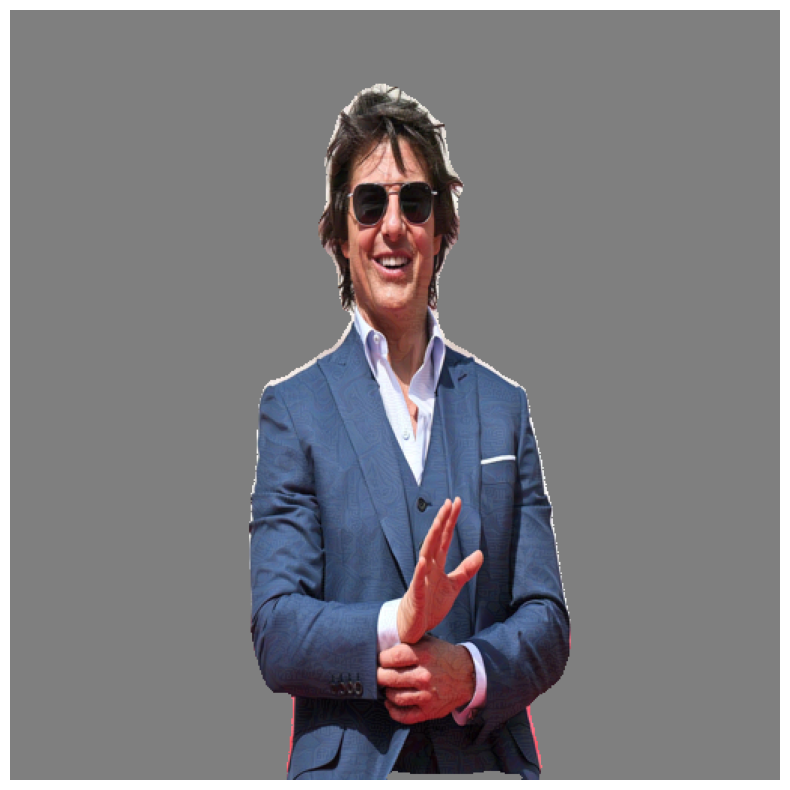

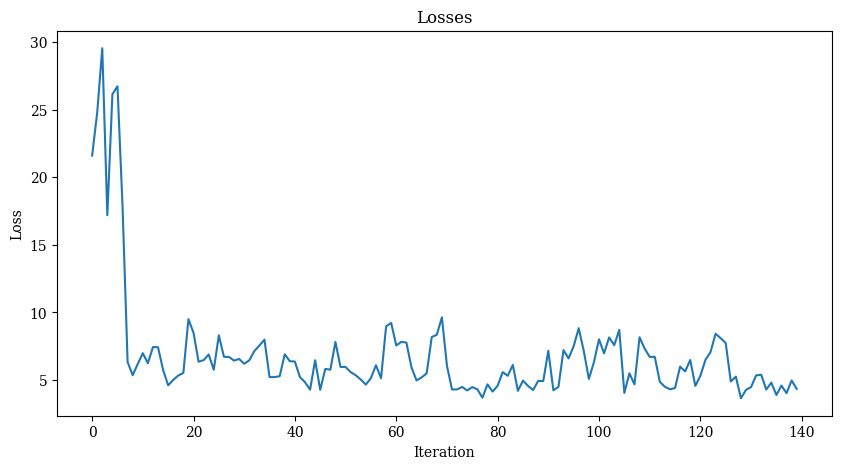

Adversarial image saved to ./adv_image.png


In [60]:
# Create a PGD attack that minimizes the attention map


# Define the loss function
def loss_fn(attention_map: list[torch.Tensor]) -> torch.Tensor:
  """Loss function that minimizes the attention map."""
  total_loss = torch.tensor(0.0, device=attention_map[0].device)
  for i, attn_map in enumerate(attention_map):
    if sum(attn_map.shape) != 4096:
      continue
    # if i > 3 and i < 26:
    #   continue
    # min_attn = attn_map.min()
    # max_attn = attn_map.max()

    # Invert the attention map between the min and max values
    # flipped_attn_map = (attn_map - min_attn) / (max_attn - min_attn)
    # flipped_attn_map = 1 - flipped_attn_map
    # flipped_attn_map = flipped_attn_map * (max_attn - min_attn) + min_attn

    # random_noise_scaled = torch.rand_like(
    #     attn_map
    # )  * (max_attn - min_attn) + min_attn
    # error = attn_map - flipped_attn_map
    # error = attn_map - random_noise_scaled
    # cosine_sim = torch.nn.functional.cosine_similarity(
    #     attn_map.flatten(), random_noise_scaled.flatten(), dim=0
    # )
    # total_loss += cosine_sim
    # total_loss += torch.sum(error**2)
    total_loss += torch.sum(attn_map**2)
  return total_loss


def pred_noise(
    unet: UNet2DConditionModel,
    text_embeddings: torch.FloatTensor,
    latents: torch.Tensor,
    mask: torch.Tensor,
    masked_image_latents: torch.Tensor,
    t: torch.Tensor,
    guidance_scale: float,
):
  latent_model_input = torch.cat([latents] * 2)
  latent_model_input = torch.cat(
      [latent_model_input, mask, masked_image_latents], dim=1
  )
  noise_pred = unet.forward(
      sample=latent_model_input,
      timestep=t,
      encoder_hidden_states=torch.cat([text_embeddings] * 2),
      return_dict=False,
  )[0]
  noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
  noise_pred_cfg = noise_pred_uncond + guidance_scale * (
      noise_pred_text - noise_pred_uncond
  )
  return noise_pred_cfg, noise_pred_text, noise_pred_uncond


def attack_forward(
    pipe: StableDiffusionInpaintPipeline,
    text_embeddings: torch.Tensor,
    masked_image: torch.Tensor,
    mask: torch.Tensor,
    random_t: torch.Tensor,
    height: int = 512,
    width: int = 512,
    num_inference_steps: int = 50,
    guidance_scale: float = 7.5,
):
  num_channels_latents = pipe.vae.config.latent_channels
  latents_shape = (1, num_channels_latents, height // 8, width // 8)
  latents = torch.randn(
      latents_shape, device=device, dtype=text_embeddings.dtype
  )

  mask = torch.nn.functional.interpolate(mask, size=(height // 8, width // 8))
  mask = torch.cat([mask] * 2)

  masked_image_latents = pipe.vae.encode(masked_image).latent_dist.sample()
  masked_image_latents = 0.18215 * masked_image_latents
  masked_image_latents = torch.cat([masked_image_latents] * 2)

  pipe.scheduler.set_timesteps(num_inference_steps)
  # timesteps_tensor = self.scheduler.timesteps.to(utils.device)
  timesteps_tensor = random_t

  for _, t in enumerate(timesteps_tensor):
    noise_pred_cfg, noise_pred_text, noise_pred_uncond = pred_noise(
        unet=pipe.unet,
        text_embeddings=text_embeddings,
        latents=latents,
        mask=mask,
        masked_image_latents=masked_image_latents,
        t=t,
        guidance_scale=guidance_scale,
    )

    latents = pipe.scheduler.step(noise_pred_cfg, t, latents).prev_sample

  return latents, [noise_pred_text, noise_pred_uncond]


def get_random_t(t_schedule, t_schedule_bound):
  result = np.empty((0), int)
  for i in t_schedule:
    cur_t = np.clip(
        np.random.normal(i, 6), i - t_schedule_bound, i + t_schedule_bound
    )
    cur_t = int(cur_t)
    result = np.append(result, cur_t)
  return torch.tensor(result)


@torch.no_grad()
def get_cond(
    pipe: StableDiffusionInpaintPipeline,
    prompt: str,
) -> torch.Tensor:
  # # Tokenize using the pipeline tokenizer
  # text_inputs = pipe.tokenizer(
  #     prompt,
  #     padding="max_length",
  #     max_length=pipe.tokenizer.model_max_length,
  #     truncation=True,
  #     return_tensors="pt",
  # )
  # text_input_ids = text_inputs.input_ids.to(device)
  # prompt_embeds = pipe.text_encoder(text_input_ids)[0]
  return pipe.encode_prompt(
      prompt,
      device=device,
      num_images_per_prompt=1,
      do_classifier_free_guidance=True,
  )[0]
  # return prompt_embeds


# Define the attack
def pgd_attack(
    image: torch.Tensor,
    mask: torch.Tensor,
    prompt: str,
    pipe: StableDiffusionInpaintPipeline,
    attention_maps: list[torch.Tensor],
    n_iter=10,
    eps=1e-2,
    lr=1e-4,
    device='cuda',
):
  """Runs a PGD attack on the image to minimize the attention map."""
  # Make sure we're using the right device
  device = torch.device(device)

  # Prepare the image and mask - Scale image to [0, 1] range if in [-1, 1]
  if image.min() < 0:
    image = (image + 1) / 2

  # Clone and detach the image, and make sure it requires gradients
  noise = torch.randn_like(image) * eps
  noise.requires_grad_(True)
  adv_image = image.clone().detach().to(device)
  adv_image.requires_grad_(False)

  # Ensure mask is on the correct device and doesn't require gradients
  mask = mask.clone().detach().to(device)

  # Create an optimizer for the image
  optimizer = torch.optim.Adam([noise], lr=lr, fused=True)

  losses = []

  for i in range(n_iter):
    # Reset gradients
    print(f"Iteration {i+1}/{n_iter}")
    optimizer.zero_grad()

    # Clear the attention maps for the new forward pass
    attention_maps.clear()

    # Forward pass through the model
    # We need to make a call that will trigger the hooks
    torch.set_grad_enabled(True)

    with torch.enable_grad():
      # Make sure we use the clone to avoid in-place modifications

      # Run the diffusion pipeline to get the latent
      text_embeddings = get_cond(pipe, prompt).to(device=device, dtype=dtype)
      # Run the inpainting pipeline at a random step between 720 and 710 from the end
      for _ in range(7):
        dropped_noise = torch.nn.functional.dropout(noise, p=0.1, training=True)
        current_image = adv_image.detach() + dropped_noise
        text_embeddings = torch.nn.functional.dropout(
            text_embeddings, p=0.1, training=True
        )

        random_t = np.random.randint(710, 720, size=(1))
        random_t = torch.tensor(random_t)
        # print("random_t: ", random_t)
        _ = attack_forward(
            pipe=pipe,
            text_embeddings=text_embeddings,
            masked_image=current_image.to(device=device, dtype=dtype),
            mask=mask.to(device=device, dtype=dtype),
            random_t=random_t,
            guidance_scale=7.5,
            height=512,
            width=512,
            num_inference_steps=50,
        )
        loss = loss_fn(attention_maps)
        losses.append(loss.item())
        loss.backward()
        attention_maps.clear()

      # Check if we have any attention maps
      # if attention_maps:
      # Compute the loss
      # print(
      #     f"Iteration {i+1}/{n_iter}, Loss: {loss.item()}, Maps collected: {len(attention_maps)}"
      # )

      # Backpropagate

      torch.nn.utils.clip_grad_norm_(noise, 1.0)
      # Update the image to minimize attention
      optimizer.step()

      # Apply the mask to keep the original content in the non-masked regions
      with torch.no_grad():
        # Make sure the image stays in [0, 1]
        # adv_image.data = torch.clamp(adv_image.data, 0, 1)
        noise.data = torch.clamp(noise.data, -eps, eps)

        # # Apply mask to keep original content in unmasked regions
        # # (1 - mask) represents the mask where we want to modify the image
        # adv_image.data = mask * image.detach() + (1 - mask) * adv_image.data
        noise.data = (1 - mask) * noise.data

  # Return the adversarial image
  print("min noise: ", noise.min())
  print("max noise: ", noise.max())
  print("min adv_image: ", adv_image.min())
  print("max adv_image: ", adv_image.max())
  return adv_image + noise, losses, noise


# Run the PGD attack
print(f"init_image shape: {init_image.shape}")
print(f"mask_image shape: {mask_image.shape}")
img, losses, noise = pgd_attack(
    image=init_image.to(device=device),
    mask=mask_image.to(device=device),
    pipe=pipe_inpaint,
    attention_maps=attention_maps,
    prompt=prompt,
    n_iter=20,
    eps=0.03 / 2,
    lr=3e-2,
)

# Plot the adversarial image
plt.figure(figsize=(10, 10))
plt.imshow(img[0].permute(1, 2, 0).detach().cpu())
plt.axis("off")
plt.show()

# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title("Losses")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

# Save the adversarial image to "adv_image.png"
save_path = "./adv_image.png"
save_img = img[0].permute(1, 2, 0).detach().cpu().numpy()
save_img = (save_img * 255).clip(0, 255).astype(np.uint8)
save_img = Image.fromarray(save_img)
save_img.save(save_path)
print(f"Adversarial image saved to {save_path}")

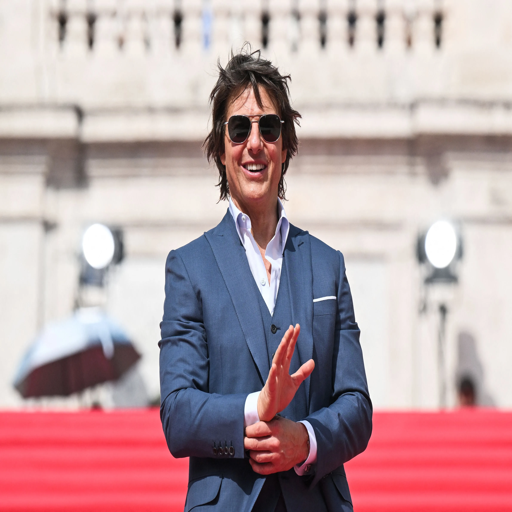

In [61]:
original_image = Image.open(image_dir +
                            image_name).convert('RGB').resize(size_2d)
original_image

In [62]:
original_image_torch = torch.tensor(
    np.array(original_image.convert("RGB")),
    dtype=torch.float32,
    device=device,
)
original_image_torch = original_image_torch.permute(2, 0, 1).unsqueeze(0)
original_image_torch = original_image_torch / 127.5 - 1.0

In [78]:
seed = 0

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

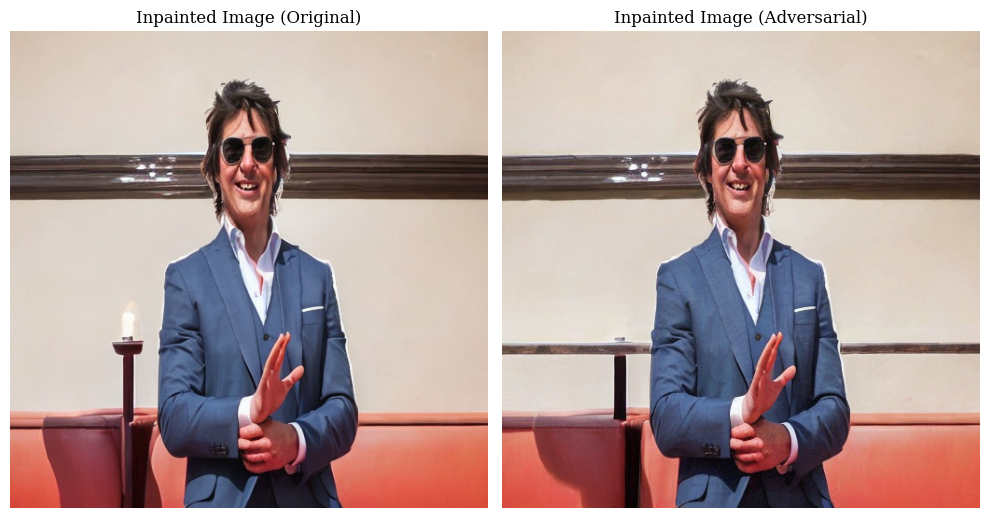

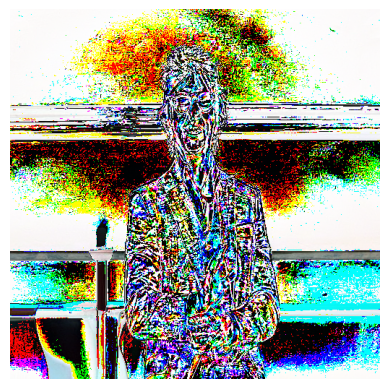

In [79]:
# Attempt to inpaint the the adversarial image
seed += 1
torch.random.manual_seed(seed)
result_1 = pipe_inpaint(
    prompt=prompt,
    image=original_image_torch,
    mask_image=mask_image.to(device=device),
    eta=1,
    num_inference_steps=50,
    guidance_scale=7.5,
    strength=0.9,
).images[0]

torch.random.manual_seed(seed)
result_2 = pipe_inpaint(
    prompt=prompt,
    image=original_image_torch + noise,
    mask_image=mask_image.to(device=device),
    eta=1,
    num_inference_steps=50,
    guidance_scale=7.5,
    strength=0.9,
).images[0]

# Plot the inpainted images
fig, axes = plt.subplots(1, 2, figsize=(10, 5.5))
axes[0].imshow(result_1)
axes[0].set_title("Inpainted Image (Original)")
axes[0].axis("off")
axes[1].imshow(result_2)
axes[1].set_title("Inpainted Image (Adversarial)")
axes[1].axis("off")
plt.tight_layout()
plt.savefig("attention_map_inpainting.png")
plt.show()

# Show the difference between the original and adversarial inpainted images
diff = (np.array(result_1) - np.array(result_2))
plt.imshow(diff, cmap="gray")
plt.axis("off")
plt.show()

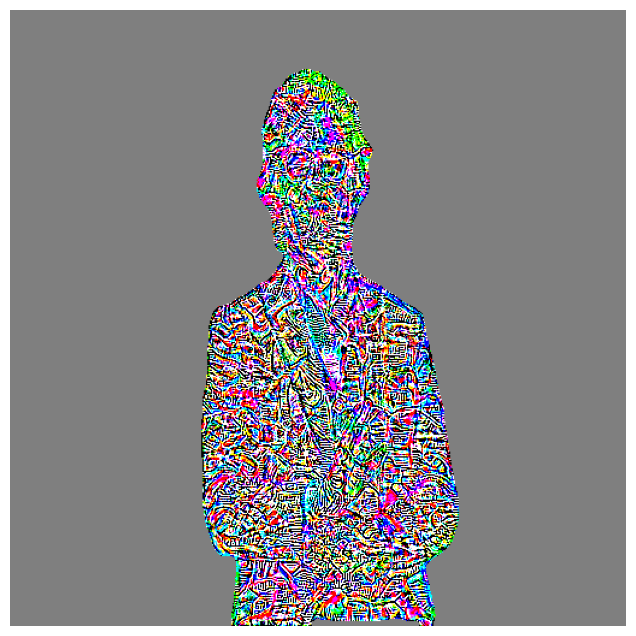

min noise:  tensor(-0.0150, device='cuda:0', grad_fn=<MinBackward1>)
max noise:  tensor(0.0150, device='cuda:0', grad_fn=<MaxBackward1>)


In [65]:
# noise
plt.figure(figsize=(8, 8))
normalised_noise = (noise - noise.min()) / (noise.max() - noise.min())
plt.imshow(normalised_noise[0].permute(1, 2, 0).detach().cpu())
# plt.imshow(noise[0].permute(1, 2, 0).detach().cpu())
plt.axis("off")
plt.show()
print("min noise: ", noise.min())
print("max noise: ", noise.max())

  0%|          | 0/1 [00:00<?, ?it/s]

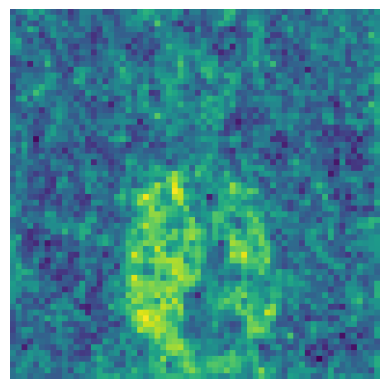

In [66]:
# Run the pipeline to extract the attention map
torch.random.manual_seed(0)

attention_maps.clear()
original_image = Image.open(image_dir +
                            image_name).convert('RGB').resize(size_2d)
original_image_torch = torch.tensor(
    np.array(original_image.convert("RGB")),
    dtype=torch.float32,
    device=device,
)
original_image_torch = original_image_torch.permute(2, 0, 1).unsqueeze(0)
original_image_torch = original_image_torch / 127.5 - 1.0
with torch.no_grad():
  # Run the pipeline
  _ = pipe_inpaint(
      prompt=prompt,
      image=original_image_torch.to(device=device),
      mask_image=mask_image.to(device=device),
      # strength=0.75,
      num_inference_steps=1,
      guidance_scale=7.5,
  )

attention_map_images = []
for i, attention_map in enumerate(attention_maps):
  # if i > 3 and i < 26:
  # continue
  square_size = int(np.sqrt(attention_map.shape[0]))
  attention_map = attention_map.view(square_size, square_size)
  # attention_map = (attention_map - attention_map.min()) / (
  #     attention_map.max() - attention_map.min()
  # )
  attention_map = attention_map.cpu().numpy()

  upsample_factor = size_2d[0] // square_size

  resized = attention_map.repeat(
      upsample_factor, axis=0
  ).repeat(
      upsample_factor, axis=1
  )
  attention_map_images.append(resized)

# Aggregate the attention maps by averaging
attention_map_image = np.zeros((size_2d[0], size_2d[1]))
for attention_map in attention_map_images:
  attention_map = np.array(attention_map)
  attention_map_image += attention_map
attention_map_image = attention_map_image / len(attention_map_images)

plt.imshow(attention_map_image, cmap="viridis")
plt.axis("off")
plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]

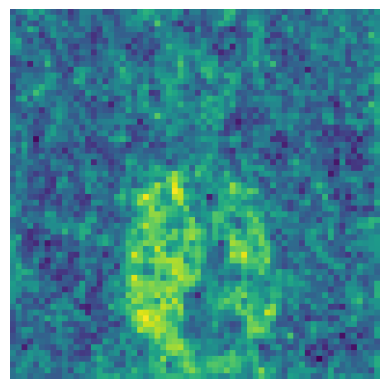

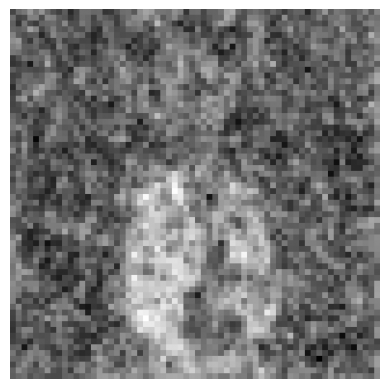

Text(0.5, 1.0, 'Distribution of Attention Map Values')

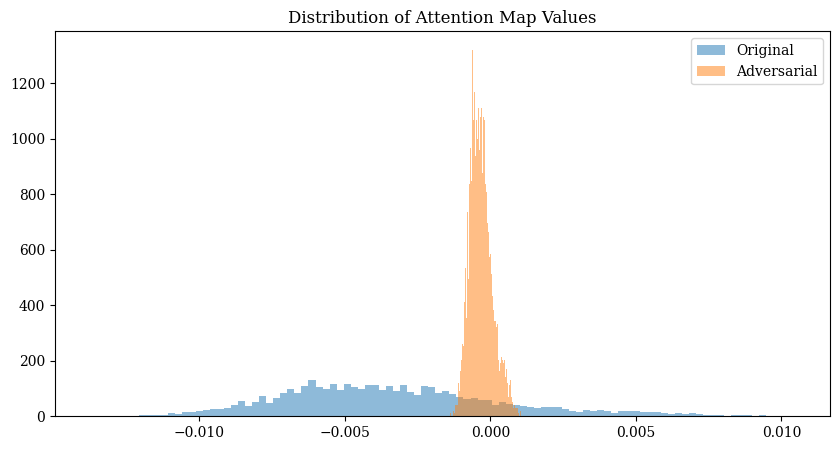

In [67]:
torch.random.manual_seed(0)

attention_maps.clear()
original_image = Image.open(image_dir +
                            image_name).convert('RGB').resize(size_2d)
original_image_torch = torch.tensor(
    np.array(original_image.convert("RGB")),
    dtype=torch.float32,
    device=device,
)
original_image_torch = original_image_torch.permute(2, 0, 1).unsqueeze(0)
original_image_torch = original_image_torch / 127.5 - 1.0
with torch.no_grad():
  # Run the pipeline
  _ = pipe_inpaint(
      prompt=prompt,
      image=original_image_torch + noise,
      mask_image=mask_image.to(device=device),
      eta=1,
      num_inference_steps=1,
      guidance_scale=7.5,
      # strength=0.8,
  )

attention_map_images = []
for i, attention_map in enumerate(attention_maps):
  # if i > 3 and i < 26:
  # continue
  square_size = int(np.sqrt(attention_map.shape[0]))
  attention_map = attention_map.view(square_size, square_size)
  # attention_map = (attention_map - attention_map.min()) / (
  #     attention_map.max() - attention_map.min()
  # )
  attention_map = attention_map.cpu().numpy()

  upsample_factor = size_2d[0] // square_size

  resized = attention_map.repeat(
      upsample_factor, axis=0
  ).repeat(
      upsample_factor, axis=1
  )
  attention_map_images.append(resized)

# Aggregate the attention maps by averaging
attention_map_image_1 = np.zeros((size_2d[0], size_2d[1]))
for attention_map in attention_map_images:
  attention_map = np.array(attention_map)
  attention_map_image_1 += attention_map
attention_map_image_1 = attention_map_image / len(attention_map_images)

plt.imshow(attention_map_image_1, cmap="viridis")
plt.axis("off")
plt.show()

# Plot the difference between the two attention maps
diff = attention_map_image - attention_map_image_1
plt.imshow(diff, cmap="gray")
plt.axis("off")
plt.show()

# Plot the distribution of the attention map values
plt.figure(figsize=(10, 5))
plt.hist(
    attention_map_image.flatten(),
    bins=100,
    density=True,
    alpha=0.5,
    label="Original"
)
plt.hist(
    attention_map_image_1.flatten(),
    bins=100,
    density=True,
    alpha=0.5,
    label="Adversarial",
)
plt.legend()
plt.title("Distribution of Attention Map Values")

In [68]:
# Find the correlation between the two attention maps
correlation = np.corrcoef(
    attention_map_image.flatten(), attention_map_image_1.flatten()
)
print(f"Correlation: {correlation[0, 1]}")

Correlation: 1.0
